# Prophet Forecasting Model (Model A - Seasonality Focus)

This notebook implements Facebook Prophet for time series forecasting with custom seasonalities and Swiss holidays.

## Prophet Advantages
- **Interpretable**: Decompose trend, seasonality, holidays
- **Robust**: Handles missing data and outliers
- **Flexible**: Custom seasonalities (quarterly, monthly patterns)
- **Business-friendly**: Easy to explain to stakeholders

## Configuration
- **Seasonality Mode**: Multiplicative (% changes over time)
- **Custom Seasonalities**: Quarterly (91.25 days), Monthly (30.5 days)
- **Swiss Holidays**: National Day, Christmas, Easter, etc.
- **Changepoint Prior**: 0.05 (moderate flexibility)

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Section 1: Load Time Series Data

In [2]:
# Load company-level time series
data_path = Path('../data/processed/monthly_aggregated_full_company.parquet')

if not data_path.exists():
    data_path = Path('../data/processed/monthly_aggregated_full_company.csv')
    df = pd.read_csv(data_path)
    df['date'] = pd.to_datetime(df['date'])
else:
    df = pd.read_parquet(data_path)

df = df.sort_values('date').reset_index(drop=True)

print(f"Loaded: {len(df)} months ({df['date'].min()} to {df['date'].max()})")

Loaded: 36 months (2022-01-01 00:00:00 to 2024-12-01 00:00:00)


## Section 2: Define Swiss Holidays

Add Swiss national holidays that may impact transport demand.

In [3]:
def create_swiss_holidays():
    """
    Create Swiss holiday dataframe for Prophet.
    
    Includes:
    - New Year's Day (Jan 1)
    - Swiss National Day (Aug 1)
    - Christmas (Dec 25-26)
    - Easter Monday (variable)
    """
    holidays = pd.DataFrame({
        'holiday': ['new_year', 'national_day', 'christmas', 'boxing_day'] * 4,
        'ds': pd.to_datetime([
            # 2022
            '2022-01-01', '2022-08-01', '2022-12-25', '2022-12-26',
            # 2023
            '2023-01-01', '2023-08-01', '2023-12-25', '2023-12-26',
            # 2024
            '2024-01-01', '2024-08-01', '2024-12-25', '2024-12-26',
            # 2025
            '2025-01-01', '2025-08-01', '2025-12-25', '2025-12-26',
        ]),
        'lower_window': 0,
        'upper_window': 1
    })
    
    # Add Easter Monday (movable feast)
    easter_dates = [
        '2022-04-18', '2023-04-10', '2024-04-01', '2025-04-21', '2026-04-06'
    ]
    easter_df = pd.DataFrame({
        'holiday': 'easter_monday',
        'ds': pd.to_datetime(easter_dates),
        'lower_window': 0,
        'upper_window': 1
    })
    
    holidays = pd.concat([holidays, easter_df], ignore_index=True)
    
    return holidays

swiss_holidays = create_swiss_holidays()
print(f"Swiss holidays defined: {len(swiss_holidays)} dates")
print(swiss_holidays.head(10))

Swiss holidays defined: 21 dates
        holiday         ds  lower_window  upper_window
0      new_year 2022-01-01             0             1
1  national_day 2022-08-01             0             1
2     christmas 2022-12-25             0             1
3    boxing_day 2022-12-26             0             1
4      new_year 2023-01-01             0             1
5  national_day 2023-08-01             0             1
6     christmas 2023-12-25             0             1
7    boxing_day 2023-12-26             0             1
8      new_year 2024-01-01             0             1
9  national_day 2024-08-01             0             1


## Section 3: Train/Validation Split

In [4]:
target_metrics = [
    'total_orders',
    'total_km_billed',
    'total_km_actual',
    'total_tours',
    'total_drivers',
    'revenue_total',
    'external_drivers',
    'vehicle_km_cost',      # NEW: KM-based transportation cost
    'vehicle_time_cost',    # NEW: Time-based transportation cost
    'total_vehicle_cost'    # NEW: Total vehicle operational cost
]

# Backward compatibility check
if 'total_km' in df.columns and 'total_km_billed' not in df.columns:
    target_metrics = [m.replace('total_km_billed', 'total_km') if m == 'total_km_billed' else m for m in target_metrics]
    target_metrics = [m for m in target_metrics if m != 'total_km_actual']  # Remove if not available

In [5]:
# Split data: Last 6 months as validation
split_date = '2024-07-01'

print("Creating train/validation split...")
print("="*80)

train_df = df[df['date'] < split_date].copy()
val_df = df[df['date'] >= split_date].copy()

# Define validation period date boundaries (needed for forecast extraction)
val_start = pd.to_datetime('2024-07-01')
val_end = pd.to_datetime('2024-12-01')
train_end = pd.to_datetime('2024-06-01')

print(f"\nTraining data:")
print(f"  Date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"  Months: {len(train_df)}")

print(f"\nValidation data:")
print(f"  Date range: {val_df['date'].min()} to {val_df['date'].max()}")
print(f"  Months: {len(val_df)}")

print(f"\n✓ Split complete!")
print(f"  Training: {len(train_df)} months (Jan 2022 - Jun 2024)")
print(f"  Validation: {len(val_df)} months (Jul 2024 - Dec 2024)")

Creating train/validation split...

Training data:
  Date range: 2022-01-01 00:00:00 to 2024-06-01 00:00:00
  Months: 30

Validation data:
  Date range: 2024-07-01 00:00:00 to 2024-12-01 00:00:00
  Months: 6

✓ Split complete!
  Training: 30 months (Jan 2022 - Jun 2024)
  Validation: 6 months (Jul 2024 - Dec 2024)


## Section 4: Prophet Model Training

Train one Prophet model per target metric.

In [6]:
def train_prophet_model(train_data, metric, holidays=None):
    """
    Train Prophet model with custom configuration.
    
    Parameters:
    -----------
    train_data : pd.DataFrame
        Training time series with 'date' column
    metric : str
        Target metric column name
    holidays : pd.DataFrame
        Holiday dataframe (optional)
    
    Returns:
    --------
    Prophet
        Trained Prophet model
    """
    # Prepare data in Prophet format
    prophet_df = pd.DataFrame({
        'ds': train_data['date'],
        'y': train_data[metric]
    })
    
    # Initialize Prophet
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,  # Monthly data, not relevant
        daily_seasonality=False,   # Monthly data, not relevant
        seasonality_mode='multiplicative',  # Percentage-based seasonality
        changepoint_prior_scale=0.05,  # Moderate flexibility (default)
        holidays=holidays,
        interval_width=0.80  # 80% confidence intervals
    )
    
    # Add custom seasonalities
    # Quarterly seasonality (91.25 days)
    model.add_seasonality(
        name='quarterly',
        period=91.25,
        fourier_order=5
    )
    
    # Monthly seasonality (30.5 days average)
    model.add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=10
    )
    
    # Fit model
    print(f"\nTraining Prophet for {metric}...")
    model.fit(prophet_df)
    print(f"✓ Training complete")
    
    return model

# Train models for each metric
prophet_models = {}

for metric in target_metrics:
    model = train_prophet_model(train_df, metric, holidays=swiss_holidays)
    prophet_models[metric] = model


Training Prophet for total_orders...


21:56:10 - cmdstanpy - INFO - Chain [1] start processing


21:56:26 - cmdstanpy - INFO - Chain [1] done processing


✓ Training complete

Training Prophet for total_km_billed...


21:56:26 - cmdstanpy - INFO - Chain [1] start processing


21:56:42 - cmdstanpy - INFO - Chain [1] done processing


✓ Training complete

Training Prophet for total_km_actual...


21:56:42 - cmdstanpy - INFO - Chain [1] start processing


21:56:58 - cmdstanpy - INFO - Chain [1] done processing


✓ Training complete



Training Prophet for total_tours...


21:56:58 - cmdstanpy - INFO - Chain [1] start processing


21:57:13 - cmdstanpy - INFO - Chain [1] done processing


✓ Training complete

Training Prophet for total_drivers...


21:57:13 - cmdstanpy - INFO - Chain [1] start processing


21:57:29 - cmdstanpy - INFO - Chain [1] done processing


✓ Training complete

Training Prophet for revenue_total...


21:57:29 - cmdstanpy - INFO - Chain [1] start processing


21:57:45 - cmdstanpy - INFO - Chain [1] done processing


✓ Training complete

Training Prophet for external_drivers...


21:57:45 - cmdstanpy - INFO - Chain [1] start processing


21:58:00 - cmdstanpy - INFO - Chain [1] done processing


✓ Training complete

Training Prophet for vehicle_km_cost...


21:58:00 - cmdstanpy - INFO - Chain [1] start processing


21:58:16 - cmdstanpy - INFO - Chain [1] done processing


✓ Training complete

Training Prophet for vehicle_time_cost...


21:58:16 - cmdstanpy - INFO - Chain [1] start processing


21:58:32 - cmdstanpy - INFO - Chain [1] done processing


✓ Training complete

Training Prophet for total_vehicle_cost...


21:58:32 - cmdstanpy - INFO - Chain [1] start processing


21:58:48 - cmdstanpy - INFO - Chain [1] done processing


✓ Training complete


## Section 5: Generate Forecasts

Generate validation forecasts and future forecasts (to Dec 2026).

In [7]:
# Generate forecasts
prophet_forecasts = {}
future_forecasts = {}

# Forecast horizon: 18 months (6 validation + 12 future)
forecast_horizon = 18

for metric, model in prophet_models.items():
    # Create future dataframe
    future = model.make_future_dataframe(periods=forecast_horizon, freq='MS')  # Month start
    
    # Generate forecast
    forecast = model.predict(future)
    
    # Extract validation period forecast
    val_forecast = forecast[
        (forecast['ds'] >= val_start) & (forecast['ds'] <= val_end)
    ]['yhat'].values
    
    prophet_forecasts[metric] = val_forecast
    future_forecasts[metric] = forecast
    
    print(f"\n{metric}:")
    print(f"  Validation forecast: {len(val_forecast)} months")
    print(f"  Full forecast: {len(forecast)} months")


total_orders:
  Validation forecast: 6 months
  Full forecast: 48 months



total_km_billed:
  Validation forecast: 6 months
  Full forecast: 48 months



total_km_actual:
  Validation forecast: 6 months
  Full forecast: 48 months



total_tours:
  Validation forecast: 6 months
  Full forecast: 48 months



total_drivers:
  Validation forecast: 6 months
  Full forecast: 48 months



revenue_total:
  Validation forecast: 6 months
  Full forecast: 48 months



external_drivers:
  Validation forecast: 6 months
  Full forecast: 48 months



vehicle_km_cost:
  Validation forecast: 6 months
  Full forecast: 48 months



vehicle_time_cost:
  Validation forecast: 6 months
  Full forecast: 48 months



total_vehicle_cost:
  Validation forecast: 6 months
  Full forecast: 48 months


## Section 6: Model Evaluation

Calculate performance metrics on validation period.

In [8]:
def calculate_metrics(y_true, y_pred, model_name, metric_name):
    """Calculate forecast accuracy metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    return {
        'model': model_name,
        'metric': metric_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Calculate metrics
results = []

for metric in target_metrics:
    y_true = val_df[metric].values
    y_pred = prophet_forecasts[metric]
    
    metrics = calculate_metrics(y_true, y_pred, 'Prophet', metric)
    results.append(metrics)

results_df = pd.DataFrame(results)

print("\nProphet Model Performance (Validation Period):")
print("="*80)
print(results_df.to_string(index=False))

# Compare with baseline (load from previous notebook)
try:
    baseline_df = pd.read_csv('../data/processed/baseline_metrics.csv')
    
    print("\n" + "="*80)
    print("Prophet vs Best Baseline:")
    print("="*80)
    
    for metric in target_metrics:
        prophet_mape = results_df[results_df['metric'] == metric]['MAPE'].values[0]
        baseline_best_mape = baseline_df[baseline_df['metric'] == metric]['MAPE'].min()
        
        improvement = ((baseline_best_mape - prophet_mape) / baseline_best_mape) * 100
        
        print(f"\n{metric}:")
        print(f"  Prophet MAPE: {prophet_mape:.2f}%")
        print(f"  Best Baseline MAPE: {baseline_best_mape:.2f}%")
        print(f"  Improvement: {improvement:+.1f}%")
except:
    print("\n⚠️  Baseline metrics not found. Run notebook 09 first.")


Prophet Model Performance (Validation Period):
  model             metric          MAE         RMSE      MAPE
Prophet       total_orders 5.692779e+04 7.933441e+04 39.549923
Prophet    total_km_billed 3.295755e+06 3.795777e+06 37.352736
Prophet    total_km_actual 1.499863e+06 1.568958e+06 65.428202
Prophet        total_tours 5.571122e+03 6.828878e+03 37.262764
Prophet      total_drivers 3.202404e+04 4.109372e+04 22.675968
Prophet      revenue_total 7.197165e+06 9.181534e+06 52.605250
Prophet   external_drivers 4.835695e+03 5.489358e+03 17.800124
Prophet    vehicle_km_cost 4.817667e+05 5.399433e+05 22.875870
Prophet  vehicle_time_cost 9.021735e+05 9.753793e+05 32.052265
Prophet total_vehicle_cost 1.079877e+06 1.253032e+06 21.544501

Prophet vs Best Baseline:

total_orders:
  Prophet MAPE: 39.55%
  Best Baseline MAPE: 2.95%
  Improvement: -1240.4%

total_km_billed:
  Prophet MAPE: 37.35%
  Best Baseline MAPE: 2.89%
  Improvement: -1191.4%

total_km_actual:
  Prophet MAPE: 65.43%
  Best B

## Section 7: Forecast Visualization

Plot Prophet forecasts with confidence intervals.

In [9]:
# Visualize forecasts
for metric in target_metrics:
    forecast_df = future_forecasts[metric]
    
    fig = go.Figure()
    
    # Historical training data
    fig.add_trace(
        go.Scatter(
            x=train_df['date'],
            y=train_df[metric],
            mode='lines+markers',
            name='Historical (Training)',
            line=dict(color='black', width=2)
        )
    )
    
    # Actual validation values
    fig.add_trace(
        go.Scatter(
            x=val_df['date'],
            y=val_df[metric],
            mode='lines+markers',
            name='Actual (Validation)',
            line=dict(color='green', width=3)
        )
    )
    
    # Prophet forecast
    fig.add_trace(
        go.Scatter(
            x=forecast_df['ds'],
            y=forecast_df['yhat'],
            mode='lines',
            name='Prophet Forecast',
            line=dict(color='blue', width=2, dash='dash')
        )
    )
    
    # Confidence interval (80%)
    fig.add_trace(
        go.Scatter(
            x=forecast_df['ds'],
            y=forecast_df['yhat_upper'],
            mode='lines',
            name='Upper 80% CI',
            line=dict(width=0),
            showlegend=False
        )
    )
    
    fig.add_trace(
        go.Scatter(
            x=forecast_df['ds'],
            y=forecast_df['yhat_lower'],
            mode='lines',
            name='Lower 80% CI',
            fill='tonexty',
            fillcolor='rgba(0, 100, 255, 0.2)',
            line=dict(width=0),
            showlegend=False
        )
    )
    
    fig.update_layout(
        title=f"Prophet Forecast - {metric.replace('_', ' ').title()}",
        xaxis_title="Date",
        yaxis_title=metric.replace('_', ' ').title(),
        height=600,
        hovermode='x unified'
    )
    
    fig.show()
    
    # Save
    results_dir = Path('../results')
    results_dir.mkdir(exist_ok=True)
    fig.write_html(results_dir / f'prophet_forecast_{metric}.html')
    print(f"\n✓ Saved: results/prophet_forecast_{metric}.html")


✓ Saved: results/prophet_forecast_total_orders.html



✓ Saved: results/prophet_forecast_total_km_billed.html



✓ Saved: results/prophet_forecast_total_km_actual.html



✓ Saved: results/prophet_forecast_total_tours.html



✓ Saved: results/prophet_forecast_total_drivers.html



✓ Saved: results/prophet_forecast_revenue_total.html



✓ Saved: results/prophet_forecast_external_drivers.html



✓ Saved: results/prophet_forecast_vehicle_km_cost.html



✓ Saved: results/prophet_forecast_vehicle_time_cost.html



✓ Saved: results/prophet_forecast_total_vehicle_cost.html


## Section 8: Component Analysis

Decompose forecast into trend, seasonality, and holiday effects.


Component Analysis - total_orders:


✓ Saved component plot: results/prophet_components_total_orders.png
  Trend (2022-2024): -23.9%
  Yearly seasonality range: 5

Component Analysis - total_km_billed:


✓ Saved component plot: results/prophet_components_total_km_billed.png
  Trend (2022-2024): +1.8%
  Yearly seasonality range: 14

Component Analysis - total_km_actual:


✓ Saved component plot: results/prophet_components_total_km_actual.png
  Trend (2022-2024): -12.9%
  Yearly seasonality range: 12

Component Analysis - total_tours:


✓ Saved component plot: results/prophet_components_total_tours.png
  Trend (2022-2024): +1.8%
  Yearly seasonality range: 6

Component Analysis - total_drivers:


✓ Saved component plot: results/prophet_components_total_drivers.png
  Trend (2022-2024): -45.9%
  Yearly seasonality range: 30

Component Analysis - revenue_total:


✓ Saved component plot: results/prophet_components_revenue_total.png
  Trend (2022-2024): -26.9%
  Yearly seasonality range: 7

Component Analysis - external_drivers:


✓ Saved component plot: results/prophet_components_external_drivers.png
  Trend (2022-2024): -52.7%
  Yearly seasonality range: 12

Component Analysis - vehicle_km_cost:


✓ Saved component plot: results/prophet_components_vehicle_km_cost.png
  Trend (2022-2024): -8.6%
  Yearly seasonality range: 6

Component Analysis - vehicle_time_cost:


✓ Saved component plot: results/prophet_components_vehicle_time_cost.png
  Trend (2022-2024): +7.1%
  Yearly seasonality range: 17

Component Analysis - total_vehicle_cost:


✓ Saved component plot: results/prophet_components_total_vehicle_cost.png
  Trend (2022-2024): -19.9%
  Yearly seasonality range: 2


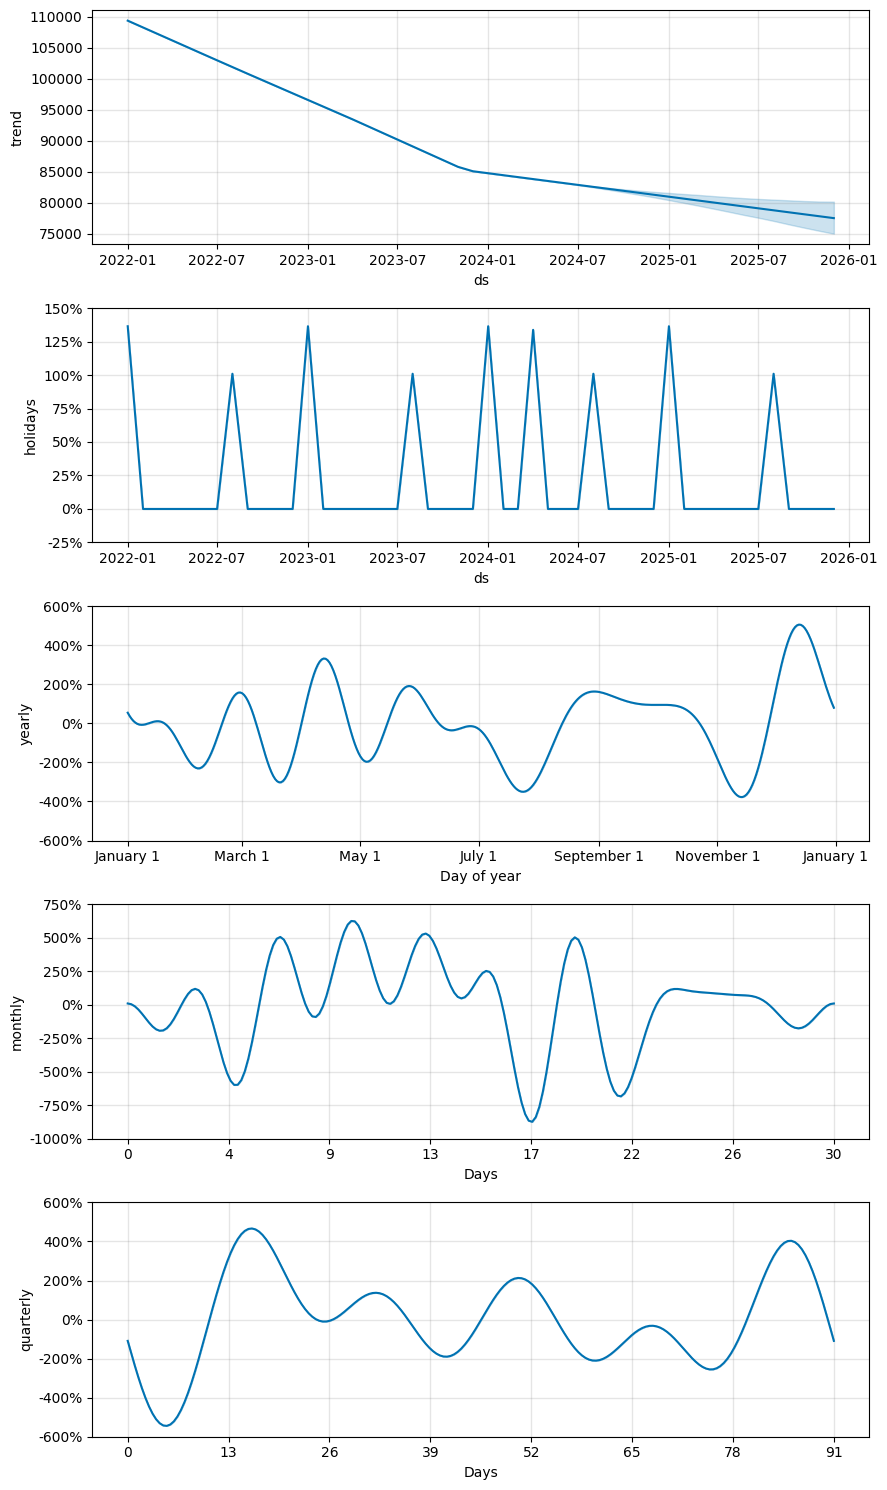

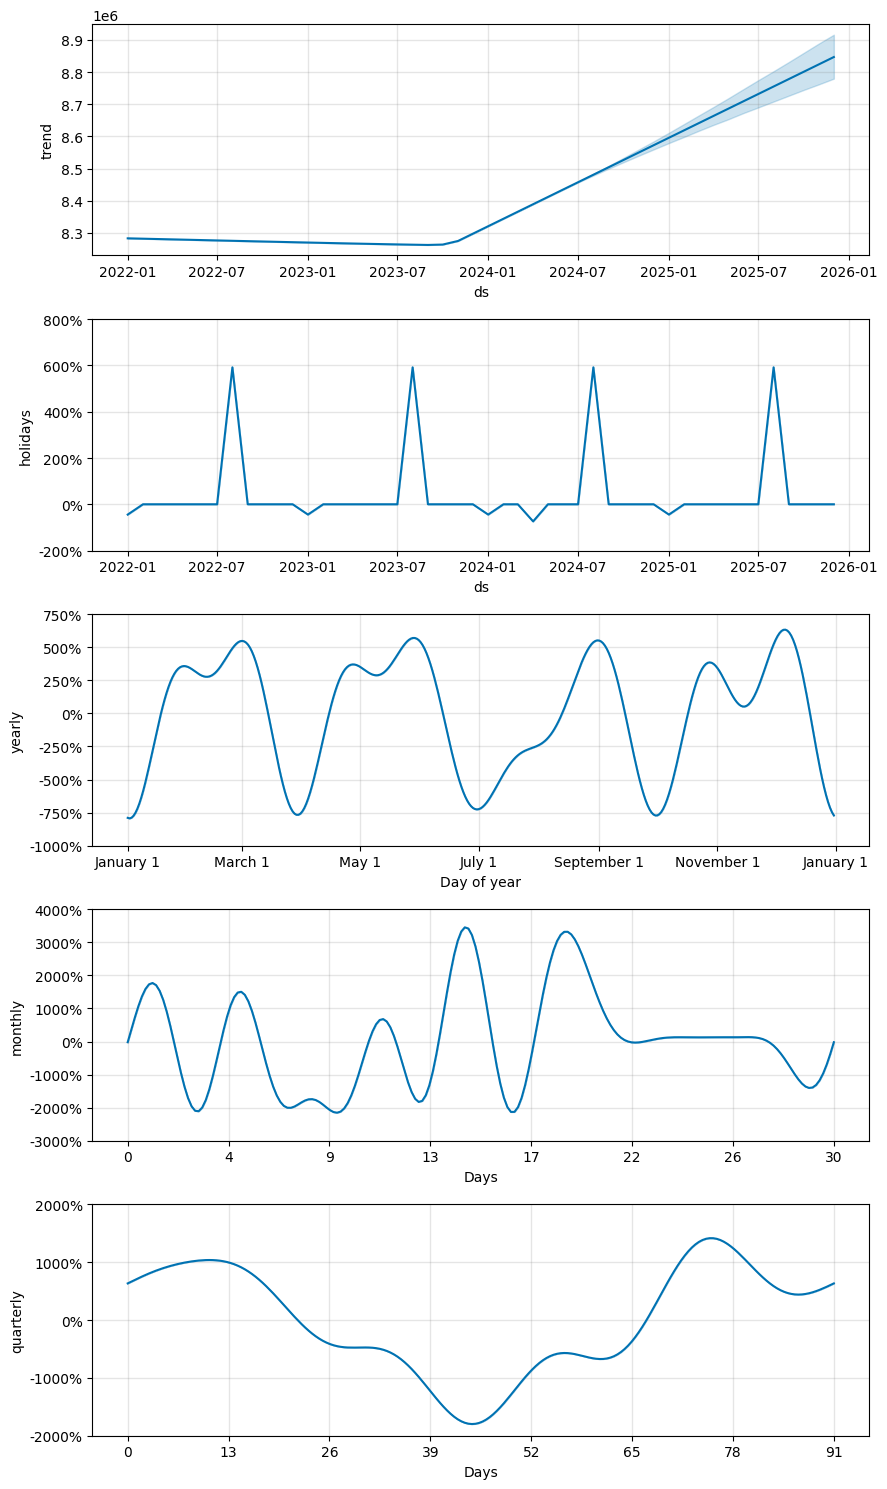

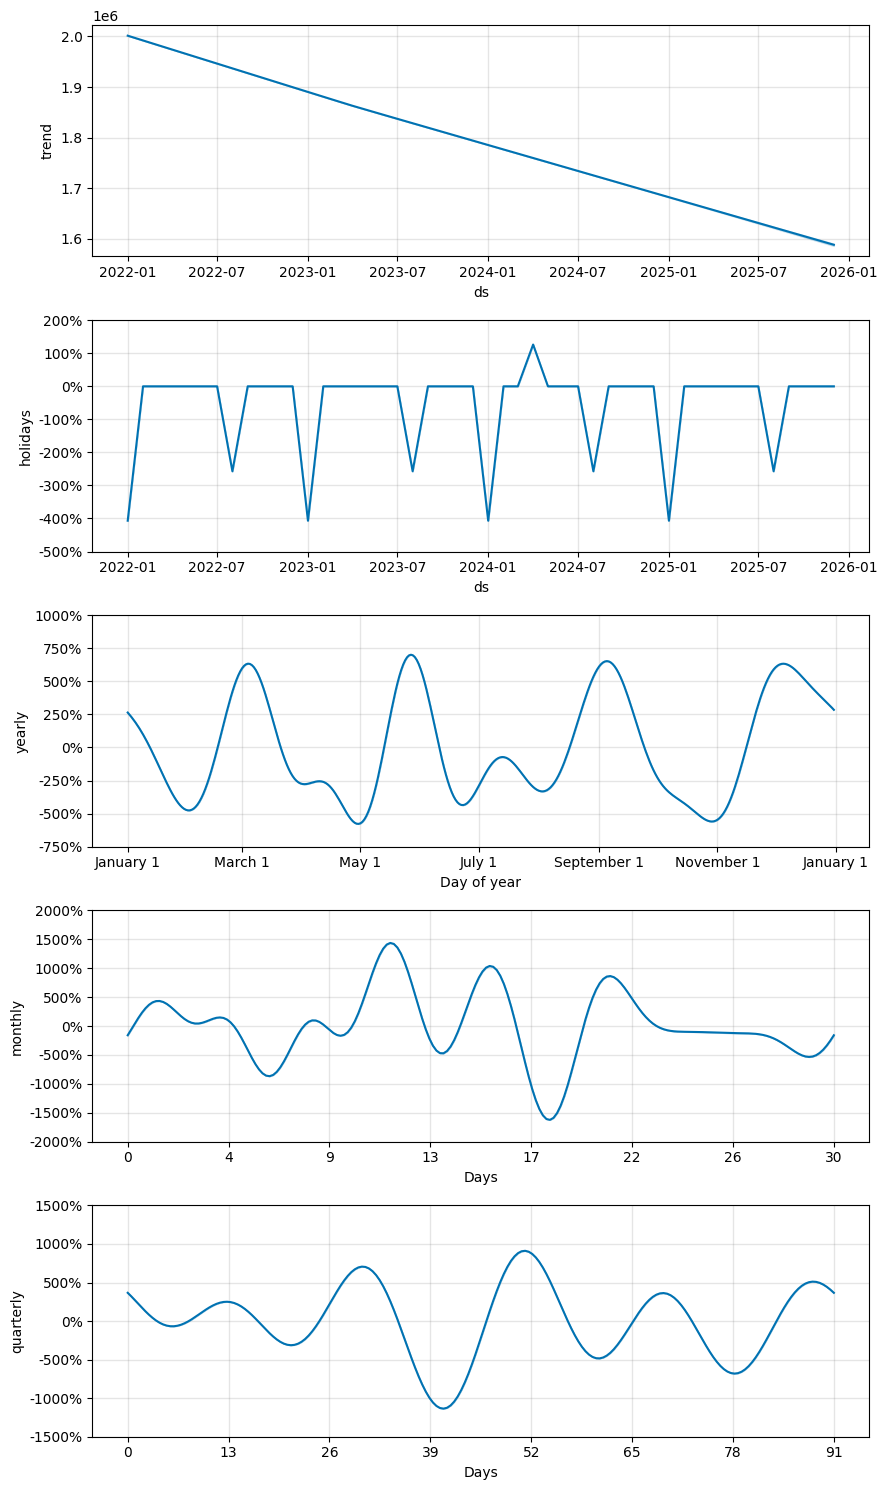

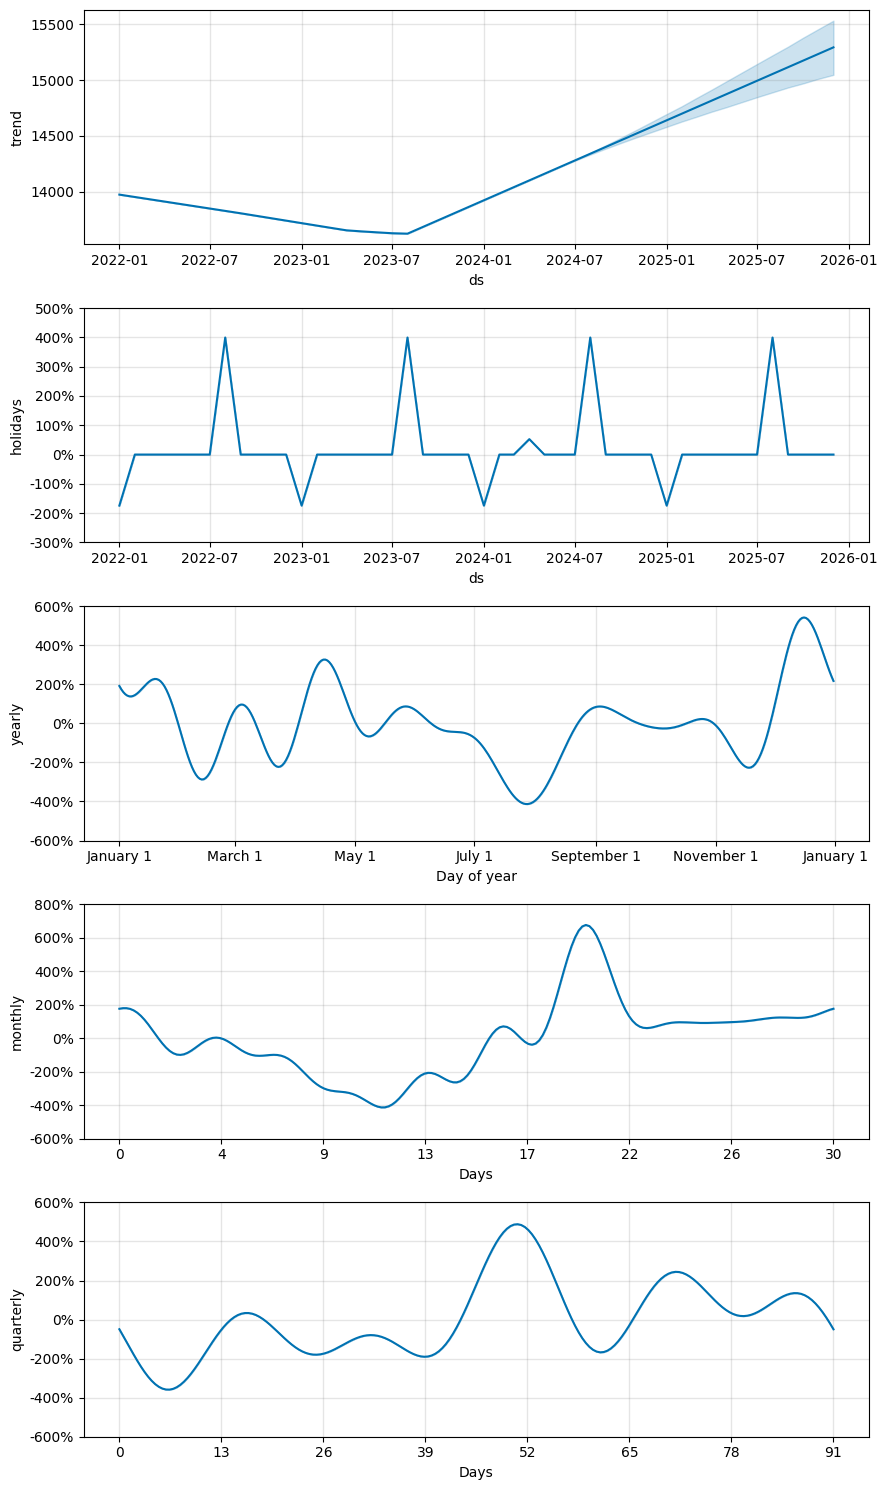

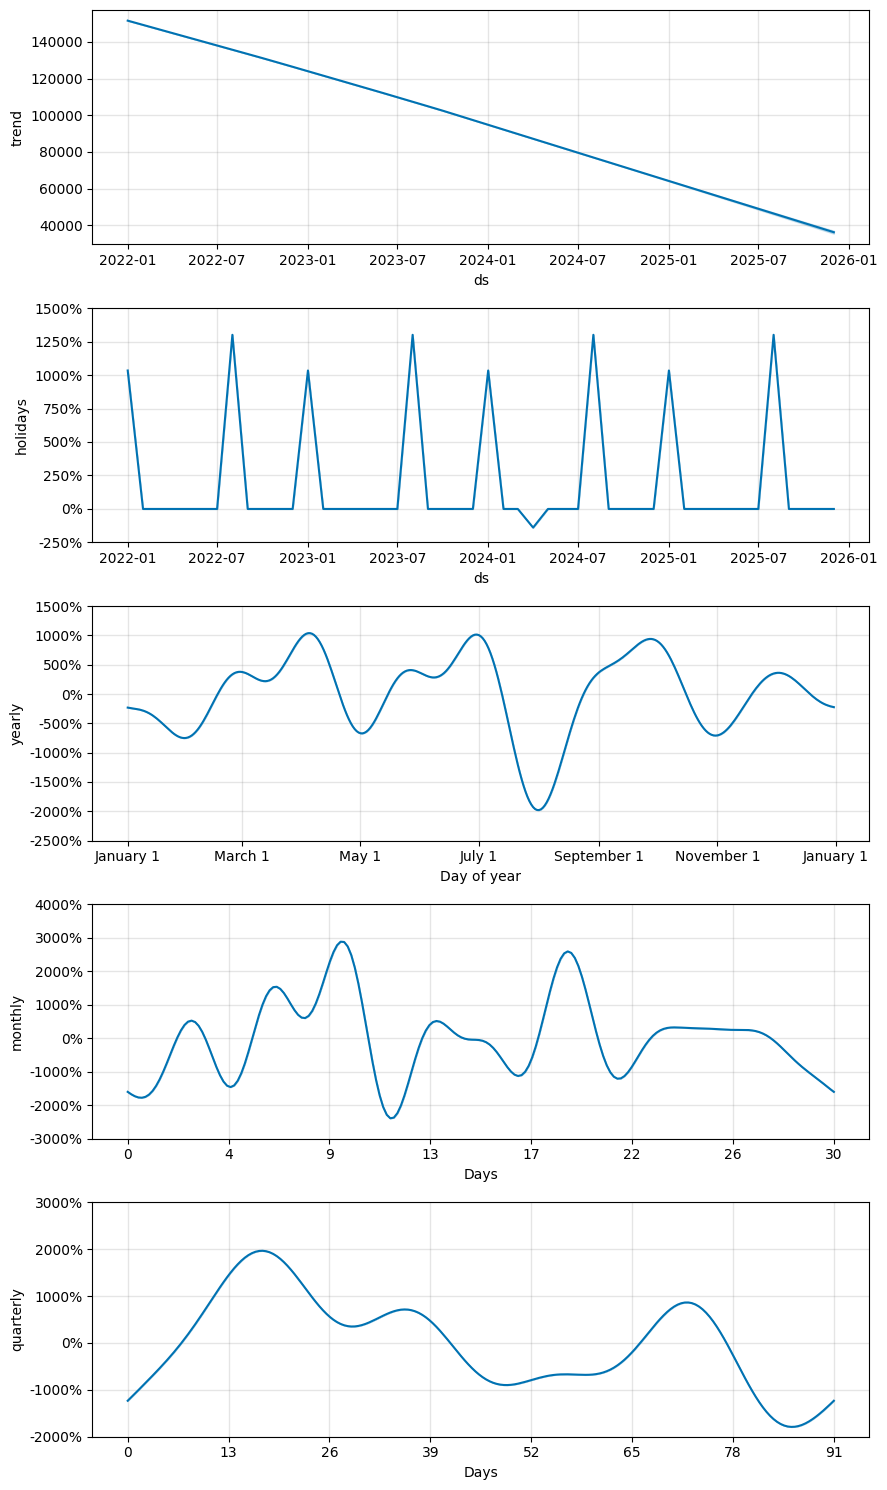

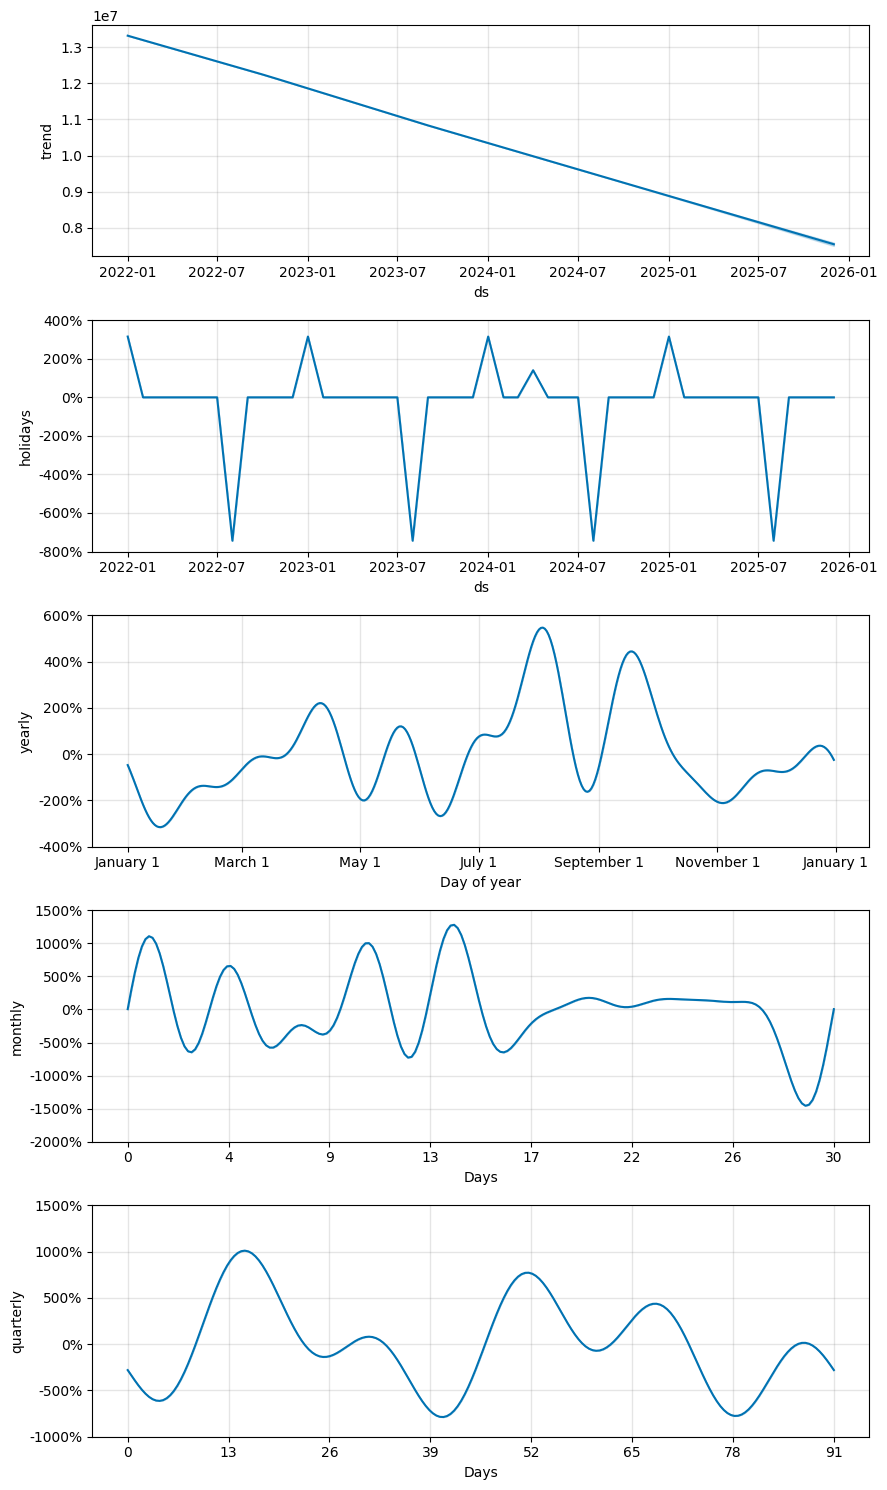

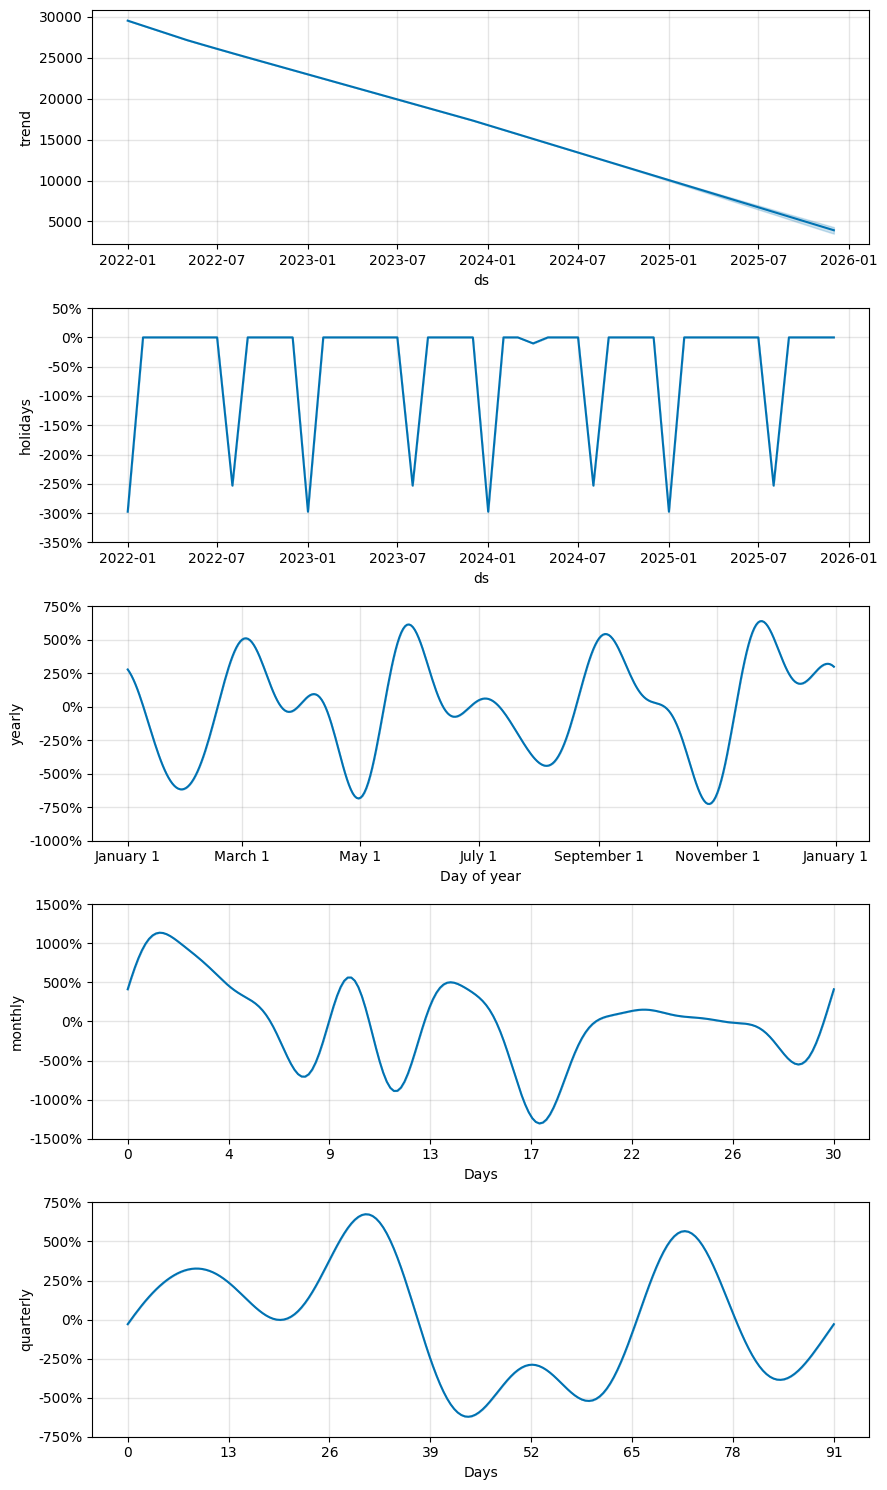

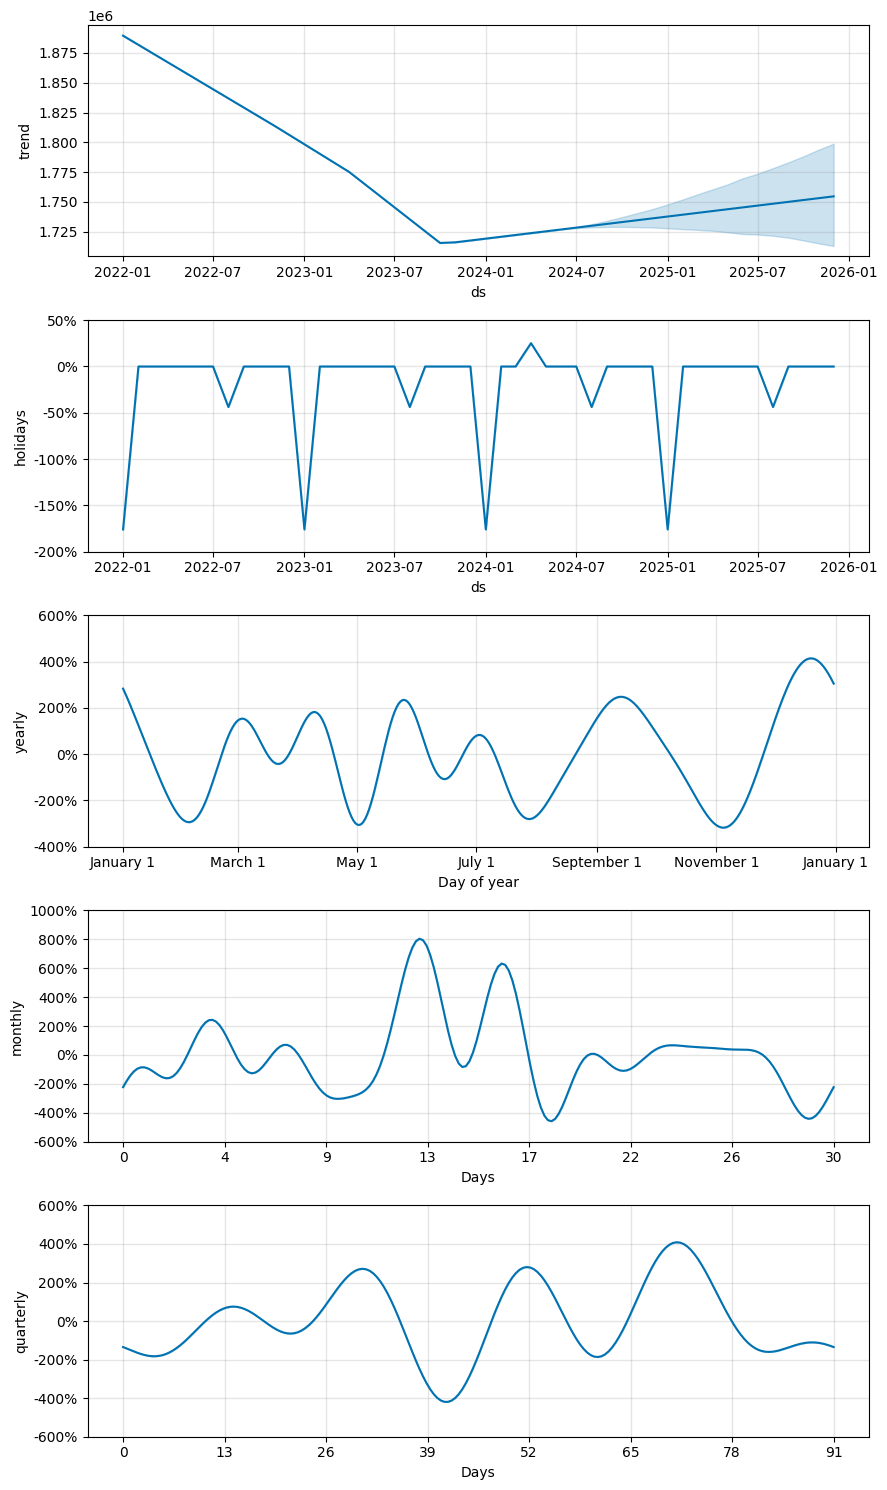

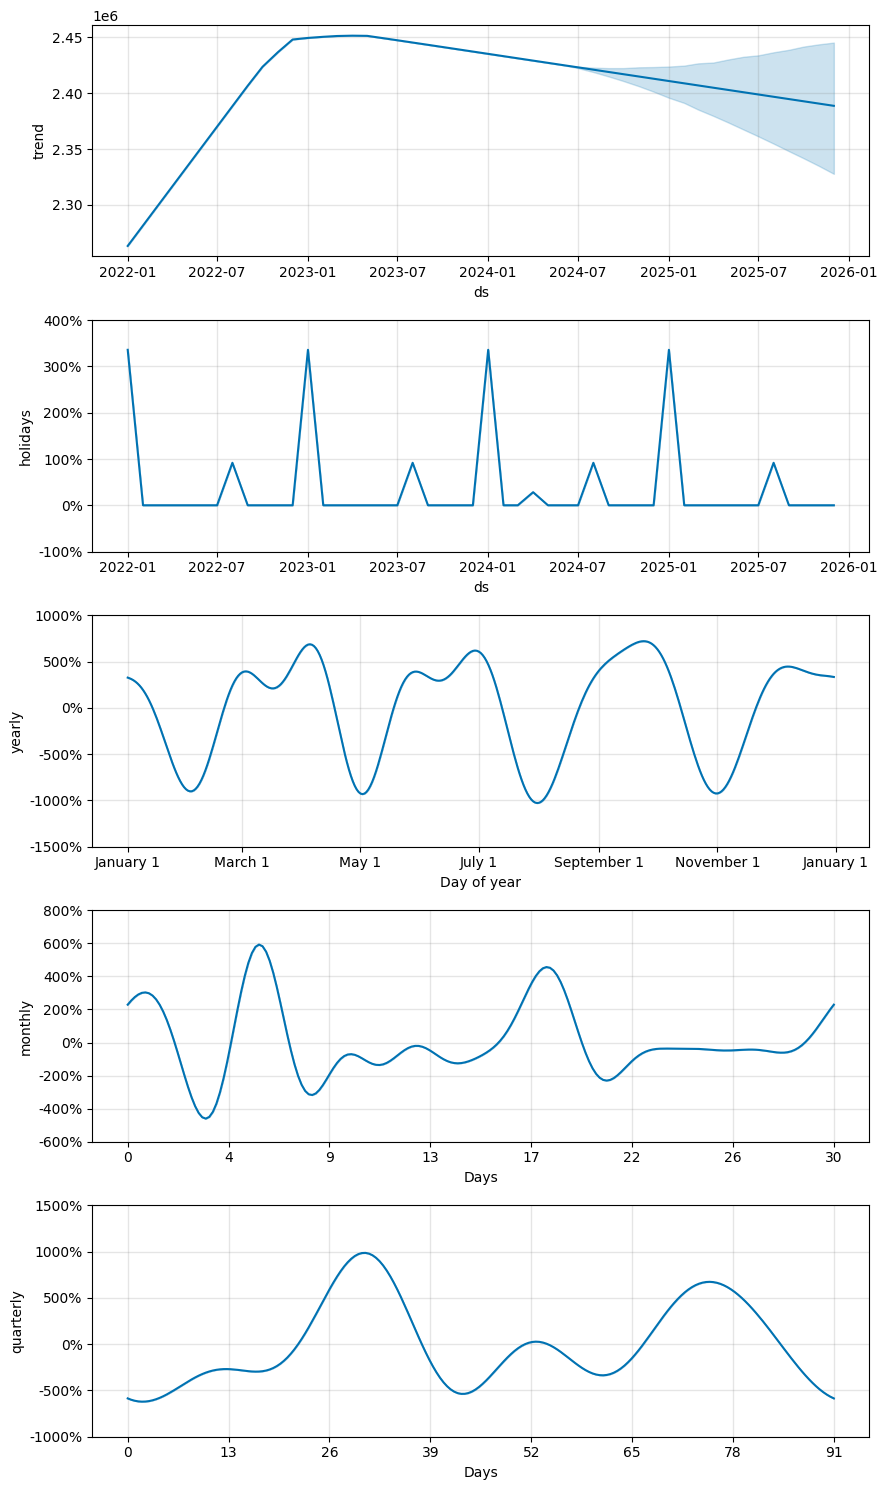

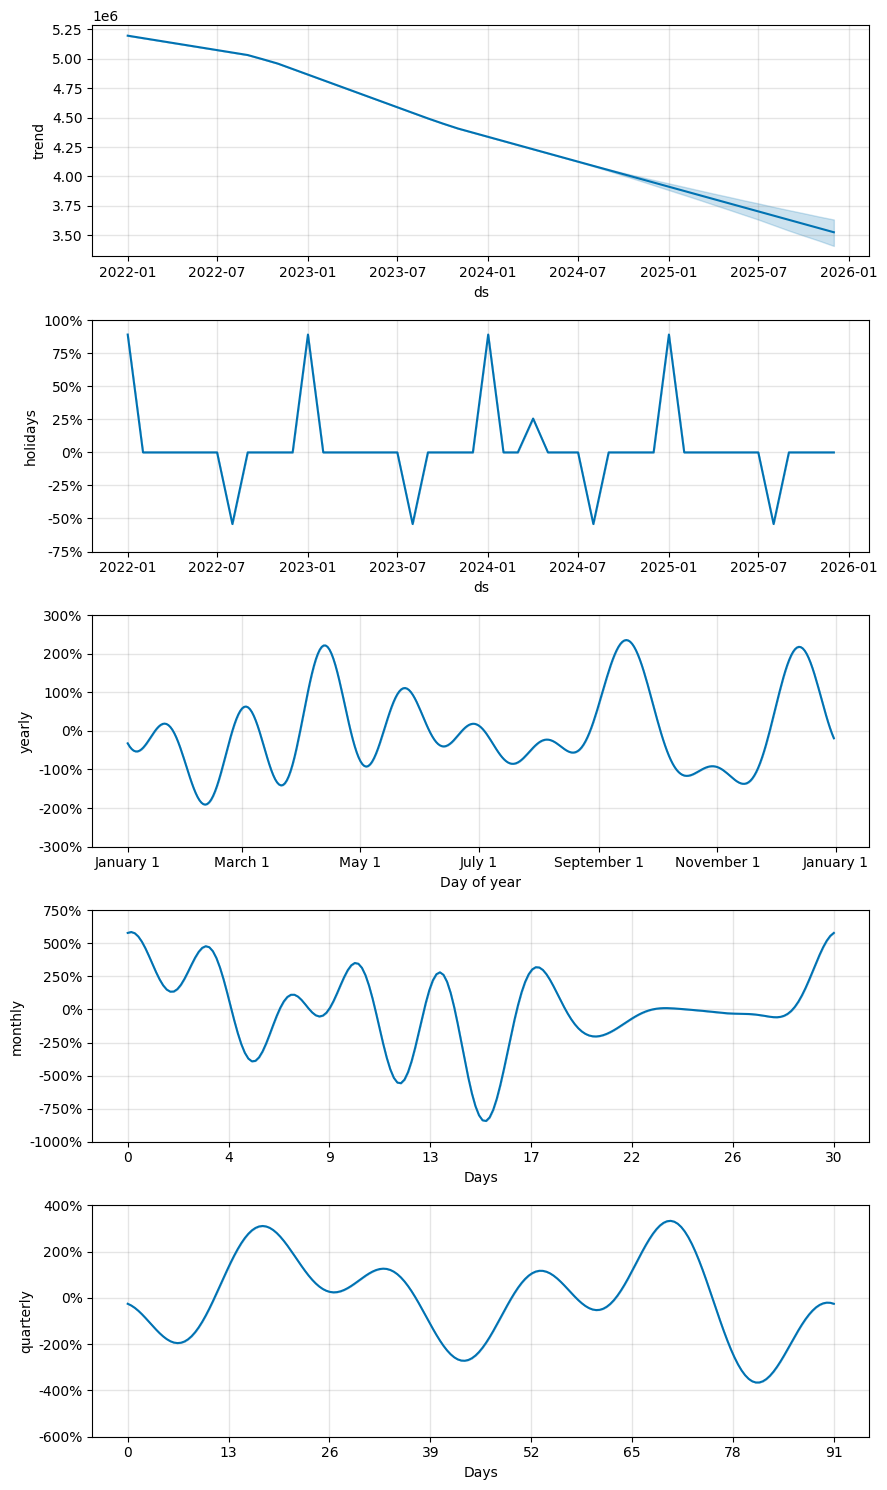

In [10]:
# Plot components for each metric
for metric in target_metrics:
    model = prophet_models[metric]
    forecast_df = future_forecasts[metric]
    
    print(f"\nComponent Analysis - {metric}:")
    print("="*50)
    
    # Create component plot
    fig = model.plot_components(forecast_df)
    fig.savefig(f'../results/prophet_components_{metric}.png', dpi=150, bbox_inches='tight')
    print(f"✓ Saved component plot: results/prophet_components_{metric}.png")
    
    # Analyze trend
    train_forecast = forecast_df[forecast_df['ds'] <= train_end]
    trend_start = train_forecast['trend'].iloc[0]
    trend_end = train_forecast['trend'].iloc[-1]
    trend_change = ((trend_end - trend_start) / trend_start) * 100
    
    print(f"  Trend (2022-2024): {trend_change:+.1f}%")
    
    # Identify strongest seasonal component
    if 'yearly' in forecast_df.columns:
        yearly_range = forecast_df['yearly'].max() - forecast_df['yearly'].min()
        print(f"  Yearly seasonality range: {yearly_range:.0f}")

## Section 9: Save Results

In [11]:
# Save performance metrics
output_dir = Path('../data/processed')
results_df.to_csv(output_dir / 'prophet_metrics.csv', index=False)
print(f"✓ Saved metrics: data/processed/prophet_metrics.csv")

# Save validation forecasts
forecast_output = pd.DataFrame({
    'date': val_df['date'],
    'year_month': val_df['year_month'].astype(str)
})

for metric in target_metrics:
    forecast_output[metric] = prophet_forecasts[metric]

forecast_output.to_csv(output_dir / 'prophet_forecast_validation.csv', index=False)
print(f"✓ Saved validation forecasts: data/processed/prophet_forecast_validation.csv")

# Save future forecasts (Jul 2025 - Dec 2026)
for metric in target_metrics:
    forecast_df = future_forecasts[metric]
    future_only = forecast_df[forecast_df['ds'] > val_end][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    future_only.columns = ['date', metric, f'{metric}_lower', f'{metric}_upper']
    
    if metric == target_metrics[0]:
        future_output = future_only
    else:
        future_output = future_output.merge(future_only, on='date')

future_output.to_csv(output_dir / 'prophet_forecast_future.csv', index=False)
print(f"✓ Saved future forecasts: data/processed/prophet_forecast_future.csv")

print(f"\n{'='*80}")
print(f"PROPHET MODEL COMPLETE!")
print(f"{'='*80}")
print(f"\nKey Findings:")
for metric in target_metrics:
    mape = results_df[results_df['metric'] == metric]['MAPE'].values[0]
    print(f"  • {metric}: MAPE = {mape:.2f}%")
print(f"\nNext: Run notebook 11 for SARIMAX model")

✓ Saved metrics: data/processed/prophet_metrics.csv


✓ Saved validation forecasts: data/processed/prophet_forecast_validation.csv


✓ Saved future forecasts: data/processed/prophet_forecast_future.csv

PROPHET MODEL COMPLETE!

Key Findings:
  • total_orders: MAPE = 39.55%
  • total_km_billed: MAPE = 37.35%
  • total_km_actual: MAPE = 65.43%
  • total_tours: MAPE = 37.26%
  • total_drivers: MAPE = 22.68%
  • revenue_total: MAPE = 52.61%
  • external_drivers: MAPE = 17.80%
  • vehicle_km_cost: MAPE = 22.88%
  • vehicle_time_cost: MAPE = 32.05%
  • total_vehicle_cost: MAPE = 21.54%

Next: Run notebook 11 for SARIMAX model
